# Tutorial 3 - Trace Elements
Simon Matthews (University of Iceland) and Kevin Wong (University of Leeds)

## Introduction

pyMelt contains a chemistry module for calculating the trace element composition of melts. There are a number of inbuilt chemical methods:
- Batch melting
- Continuous melting, which can be used to calculate either instantaneous or accumulated melts
- Invmel, following McKenzie & O'Nions (1991), incorporates the effect of aluminous phase transitions and phase exhaustion
Currently the methods all use constant partition coefficients, but soon using pressure and temperature dependent partition coeffients will be an option.

The module is designed to allow maximum customisation of the calculations, but using the default options is very straightforward. Invmel is used for most elements by default, with the exception of the most incompatible elements, which are modelled assuming continuous melting with 0.5% porosity. See the documentation for more information about the partition coefficients used.

First we must import the required modules as before:

In [1]:
import pyMelt as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Making MORB from a homogeneous mantle
In the first example we will predict the composition of a spreading centre basalt using the default options.

First we must create a `Mantle` object and perform adiabatic melting, as before:

In [2]:
lz = m.lithologies.matthews.klb1()
mantle = m.Mantle([lz], [1.0], ['lz'])
column = mantle.AdiabaticMelt(1350.0)

We must now add chemistry to these melts. The default options are designed for melting depleted mantle, so we don't need to set up or pass any additional arguments:

In [3]:
column.calculate_chemistry()

Lithology composition is set to the depleted mantle of Workman & Hart (2005).


Notice that pyMelt told us it was setting the composition to the depleted mantle. See below for how to adjust this. At this point we can already inspect some of the instantaneous results:

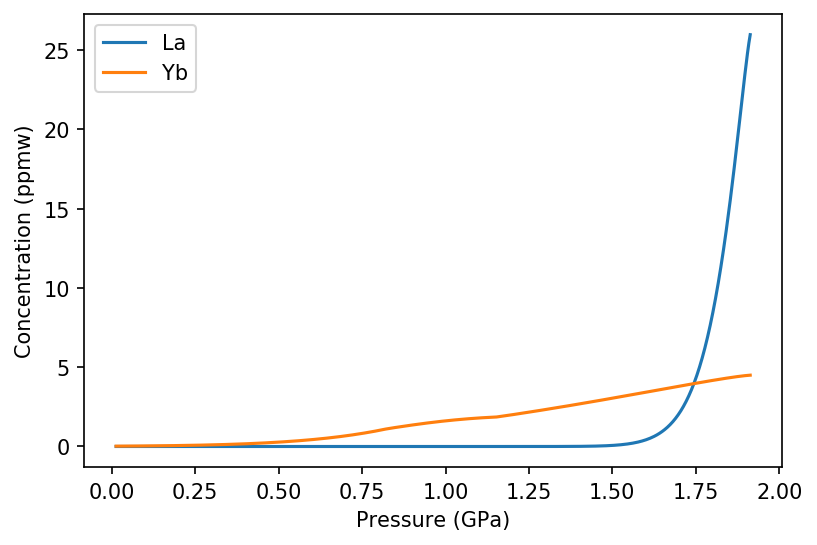

In [4]:
f, a = plt.subplots(dpi=150)
a.plot(column.P, column.lithologies['lz']['La'], label='La')
a.plot(column.P, column.lithologies['lz']['Yb'], label='Yb')

a.set_ylabel('Concentration (ppmw)')
a.set_xlabel('Pressure (GPa)')
a.legend()
plt.show()

Notice how Yb behaves more compatibly than La, persisting for much longer in melts. The subtle change in gradient in the Yb line occurs during the spinel to plagioclase transition.

When the `SpreadingCentre` `GeoSetting` class is created pyMelt automatically calculates the crustal thickness based on a triangular melting region with passive upwelling (as shown in Tutorial 1). If the `MeltingColumn` class contains chemistry, creating the `GeoSetting` class also applies the appropriate homogenisation calculation. For a spreading centre this is homogenisation with a triangular weighting.

In [5]:
morb = m.geosettings.SpreadingCentre(column)

We can view the raw homogenised trace element concentrations:

In [6]:
morb.chemistry

Rb       0.396402
Ba       4.461680
Th       0.062251
U        0.025427
Nb       1.183375
Ta       0.076496
La       1.509458
Ce       4.252900
Pb       0.142395
Pr       0.807481
Nd       4.248332
Sr      59.324005
Zr      37.916025
Hf       1.073972
Sm       1.648624
Eu       0.654300
Ti    4320.851395
Gd       2.435299
Tb       0.464154
Dy       3.370168
Ho       0.765611
Y       20.813260
Er       2.181567
Yb       2.182753
Lu       0.334373
dtype: float64

But to really make sense of the results it is convenient to make a spider diagram, for which the `GeoSetting` classes have a built in method. There are many ways to customise the plot, most importantly the reference values used for normalisation. The default normalisation is the primitive mantle of Palme & O'Neill (2013).

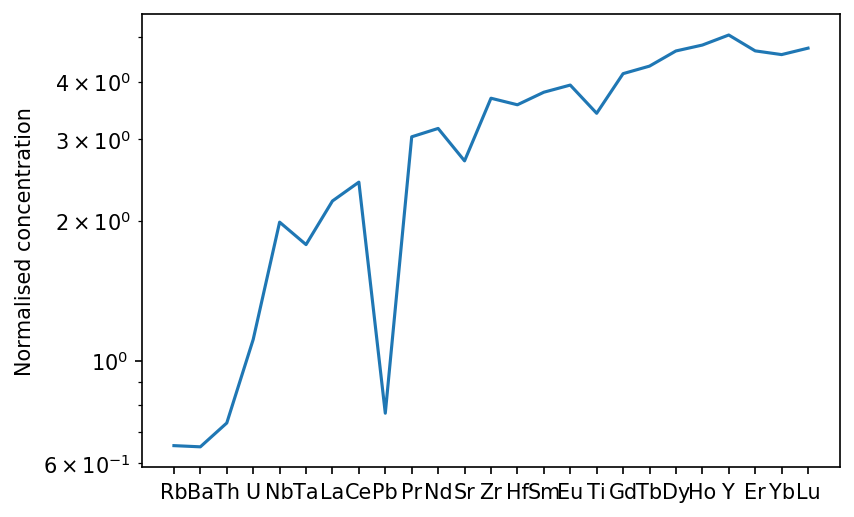

In [7]:
f,a = morb.plot_spider()
plt.show()

If we wanted to see just the rare earth elements, we can specify this. We can also normalise to chondrite, and show the range of instantaneous melts:

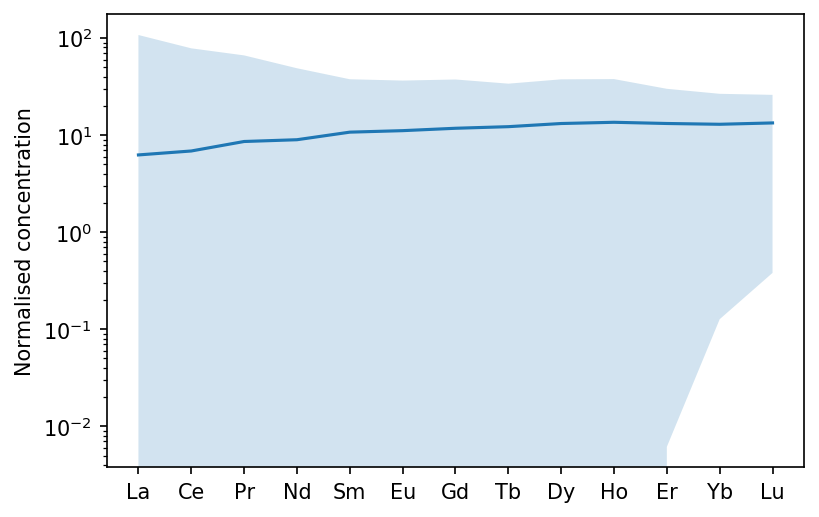

In [8]:
f,a = morb.plot_spider(element_order=['La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Yb','Lu'], 
                       normalisation='CI', plot_instantaneous=True)
plt.show()

Finally, we can see what the effect of some crystal fractionation would be on the composition. This time I will normalise to depleted mantle, to remove the Pb anomaly.

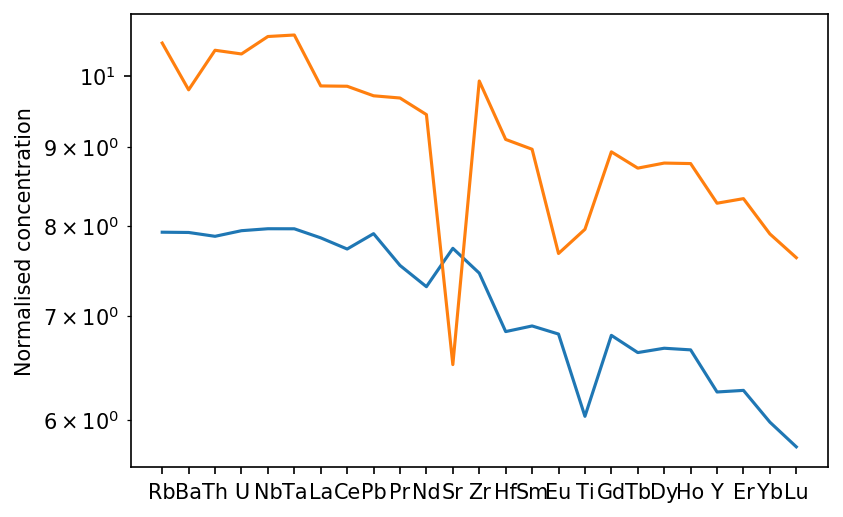

In [9]:
f,a = morb.plot_spider(normalisation='DM', crystal_fraction={'olv':0.05, 'plg':0.2})
plt.show()

Crystallising olivine and plagioclase has enriched the melt in trace elements, with the exception of Sr, since it is very compatible in plagioclase. Eu also shows a negative anomaly owing also to its relative compatibility in plagioclase. The crystallisation calculation can also be used independently of plotting. In fact the plotting method just calls the `GeoSetting.crystallisation_chemistry()` itself. See the documentation for `GeoSetting.crystallisation_chemistry()` for information about customising the crystallisation calculation.

## Making OIB from a heterogeneous mantle
In addition to calculating the trace element concentrations in melts from a homogeneous mantle, pyMelt allows the trace element contents of melts from multiple lithologies to be calculated simultaneously. However, pyMelt requires additional input to tell it how to treat the lithologies. This is partly from a practical stand point- one set of default options for pyroxenite (for example) is unlikely to be relevant to many calculations.

Like before we start by setting up a mantle and melting it by adiabatic decompression:

In [18]:
px = m.lithologies.matthews.kg1()
hz = m.lithologies.shorttle.harzburgite()
mantle = m.Mantle([lz, px, hz], [0.7, 0.2, 0.1], ['lz','px','hz'])
oi_col = mantle.AdiabaticMelt(1480.0)

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/pyMelt/mantle_class.py:470: UserWarning: Freezing prevented.
  warn("Freezing prevented.")


pyMelt has some published mantle compositions built in, for example the subducted oceanic crust composition calculated by Stracke et al. (2003):

In [19]:
m.chemistry.stracke03_bsic

{'Rb': 0.57,
 'Ba': 6.59,
 'Th': 0.088,
 'U': 0.027,
 'Nb': 1.95,
 'Ta': 0.124,
 'La': 1.68,
 'Ce': 5.89,
 'Pb': 0.09,
 'Nd': 7.45,
 'Sr': 81.0,
 'Zr': 64.0,
 'Hf': 1.78,
 'Sm': 2.69,
 'Eu': 1.04,
 'Ti': 7735.0,
 'Gd': 4.03,
 'Dy': 5.01,
 'Y': 28.5,
 'Er': 3.13,
 'Yb': 2.99,
 'Lu': 0.45}

The KG1 bulk composition used as the pyroxenite endmember is a mixture of oceanic crust and lherzolite peridotite. We can mirror this in the trace elements by calculating a mix of the subducted crust composition and the depleted mantle composition. Note that the `dict` objects have to be converted to `pandas.Series` objects before applying mathematical operations, and then converted back before feeding to pyMelt.

In [29]:
kg1_tes = (1.0 * pd.Series(m.chemistry.stracke03_bsic) + 
           0.0 * pd.Series(m.chemistry.workman05_dmm))
kg1_tes = kg1_tes[~np.isnan(kg1_tes)]
kg1_tes = dict(kg1_tes)
kg1_tes

{'Ba': 6.59,
 'Ce': 5.89,
 'Dy': 5.01,
 'Er': 3.13,
 'Eu': 1.04,
 'Gd': 4.03,
 'Hf': 1.78,
 'La': 1.68,
 'Lu': 0.45,
 'Nb': 1.95,
 'Nd': 7.45,
 'Pb': 0.09,
 'Rb': 0.57,
 'Sm': 2.69,
 'Sr': 81.0,
 'Ta': 0.124,
 'Th': 0.088,
 'Ti': 7735.0,
 'U': 0.027,
 'Y': 28.5,
 'Yb': 2.99,
 'Zr': 64.0}

We now have to start setting up the chemistry calculation. We can use the default models again (which for most elements is invmel), but the parameters controlling invmels behaviour will be different for pyroxenite.

To see what parameters are required, we can look at the `invmelSpecies` object documentation:

In [30]:
m.chemistry.invmelSpecies?

Init signature:
m.chemistry.invmelSpecies(
    name,
    c0,
    olv_D,
    cpx_D,
    opx_D,
    spn_D,
    grt_D,
    plg_D,
    mineralProportions=             olv    opx    cpx    grt    spn    plg
grt_field  0.598  0.221  0.076  0.115  0.000  0.000
spn_field  0.578  0.270  0.119  0.000  0.033  0.000
plg_field  0.636  0.263  0.012  0.000  0.000  0.089,
    density=3.3,
    modal='NonModalFixed',
    cpxExhaustion=0.18,
    garnetInCoeffs=[666.7, 400.0],
    spinelOutCoeffs=[666.7, 533.0],
    plagioclaseInInterval=[25.0, 35.0],
    **kwargs,
)
Docstring:     
Implementation of the forward trace element model used by invmel (McKenzie & O'Nions, 1991).

The default values of the mineral-melt partition coefficients are taken from REFERENCE.

Parameters
----------
name :  str
    The name of the species.
c0 :    float
    The concentration of the species in the solid. Must be the same units as required in the
    output.
olv_D : float
    The partition coefficient for olivine-melt.
cpx

Cpx (and grt) persists to much higher melt fractions during pyroxenite melting, though the melt fraction at cpx-exhaustion varies somewhat with pressure. Assuming exhaustion at 60% melting errs towards the low pressure results (it persists for longer at higher pressures)

In [31]:
cpxExhaustion = 0.6

For simplicity we will translate the spinel-out reaction from lherzolite to lower pressures for the pyroxenite, and use an identical line for garnet-in:

In [32]:
spinelOutCoeffs = [666.7, 50]
garnetInCoeffs = [666.7, 50]

We will not change the plagioclase-spinel interval (it is not so different between KG1 and KLB1).

Perhaps most importantly, we must change the proportions of mineral phases present. Fortunately, pyMelt has the mineral proportions for KG1 stored already in the chemistry module:

In [33]:
m.chemistry.kg1_MineralProportions

,olv,opx,cpx,grt,spn,plg
grt_field,0.181,0.012,0.422,0.385,0.000,0.000
spn_field,0.110,0.178,0.641,0.000,0.071,0.000
plg_field,0.118,0.150,0.655,0.000,0.000,0.067


We must then feed this information to the chemistry module. Notice that the parameters must be provided for each lithology (even the non-melting harzburgite!). I copied the values for lherzolite from the default values printed in the docstring above.

In [34]:
oi_col.calculate_chemistry(elements = {'lz': m.chemistry.workman05_dmm,
                                       'px': kg1_tes,
                                       'hz': m.chemistry.workman05_dmm}, # Doesn't matter what value
                           cpxExhaustion = {'lz': 0.18,
                                            'px': cpxExhaustion,
                                            'hz': 0.1}, # Doesn't matter what value
                           garnetInCoeffs = {'lz': [666.7, 400.0],
                                             'px': garnetInCoeffs,
                                             'hz': [0,0]},
                           spinelOutCoeffs = {'lz': [666.7, 533.0],
                                              'px': spinelOutCoeffs,
                                              'hz': [0,0]}, # Doesn't matter what value
                           mineralProportions = {'lz': m.chemistry.klb1_MineralProportions,
                                                 'px': m.chemistry.kg1_MineralProportions,
                                                 'hz': m.chemistry.klb1_MineralProportions} # Doesn't matter what value
                          )

As before we can view the instantaneous melts within the `MeltingColumn` object, here we can compare the two melting lithologies:

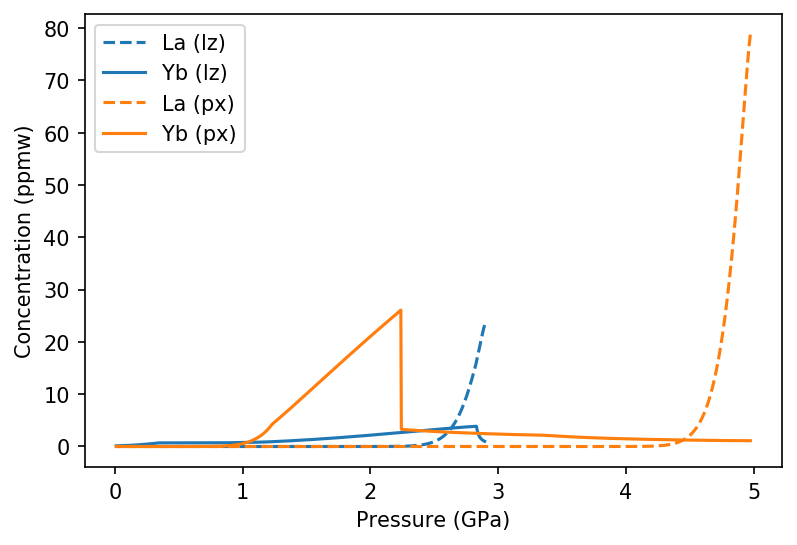

In [35]:
f, a = plt.subplots(dpi=150)
a.plot(oi_col.P, oi_col.lithologies['lz']['La'], label='La (lz)', ls='--', c='C0')
a.plot(oi_col.P, oi_col.lithologies['lz']['Yb'], label='Yb (lz)', ls='-', c='C0')

a.plot(oi_col.P, oi_col.lithologies['px']['La'], label='La (px)', ls='--', c='C1')
a.plot(oi_col.P, oi_col.lithologies['px']['Yb'], label='Yb (px)', ls='-', c='C1')

a.set_ylabel('Concentration (ppmw)')
a.set_xlabel('Pressure (GPa)')
a.legend()
plt.show()

To see the homogenised melt that would be erupted through thick lithosphere (1.5 GPa at the base in the example here), we can create an `oceanIsland` class:

In [40]:
oib = m.geosettings.OceanIsland(oi_col, 4.0)

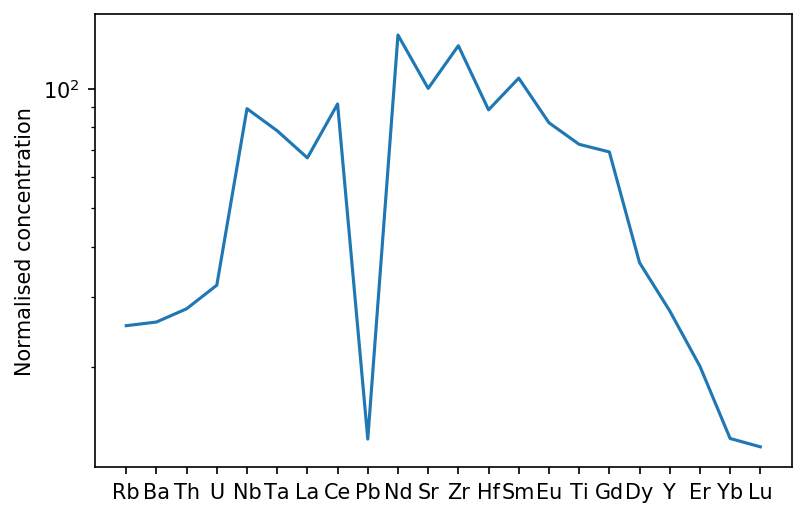

In [41]:
f,a = oib.plot_spider()

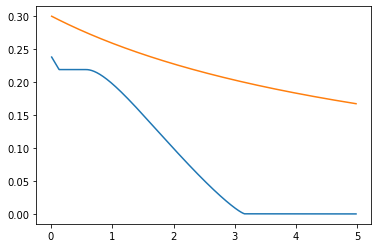

In [5]:
f,a = plt.subplots()
a.plot(oi_col.P, oi_col.lithologies['lz'].F)
a.plot(oi_col.P, lz._FcpxOut(oi_col.P))
# a.plot(oi_col.P, lz._Fcpx(oi_col.T, oi_col.P))
# a.plot(oi_col.P, lz._Fopx(oi_col.T, oi_col.P))
plt.show()

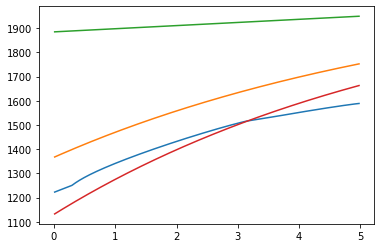

In [6]:
f,a = plt.subplots()
a.plot(oi_col.P, oi_col.T)
a.plot(oi_col.P, lz._TLherzLiquidus(oi_col.P))
a.plot(oi_col.P, lz.TLiquidus(oi_col.P))
a.plot(oi_col.P, lz.TSolidus(oi_col.P))
plt.show()

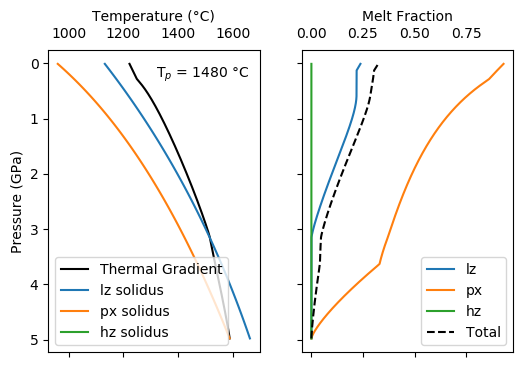

In [7]:
f,a = oi_col.plot()
plt.show()

In [29]:
lz._FcpxOut(0.3)

0.2862595419847328

In [50]:
any(np.array([0.1,0.5,0.7])[x] > np.array([0.2,0.2,0.8])[x] for x in range(3))

True